# Random Forest with Dimensionality Reduction (PCA): From Scratch vs Library (Window Size = 14)

- Dataset: `CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv`
- Target: `Target_Return_7d` mapped to 3 classes
  - Uptrend: `> 0.03`
  - Downtrend: `< -0.03`
  - Sideway: otherwise
- Features: selected from `CLASSIFY-AMZN_methods_all_in_one.csv`
- Dimensionality Reduction: **PCA** (Principal Component Analysis)
- Models:
  1. Random Forest (from scratch — bootstrap + decision tree ensemble with majority voting)
  2. Random Forest (scikit-learn RandomForestClassifier)

Outputs:
- Loss
- Confusion matrix
- Accuracy
- Precision, Recall, Specificity (macro), F1-score
- ROC & AUC (multiclass, OvR)
- Performance curves (loss and accuracy vs number of trees)

Rows after cleaning: 4022
Number of features used: 9
Features used: ['ma_gap_20', 'vol_10', 'vol_20', 'lower_wick', 'upper_wick', 'ret_1', 'range_pct', 'co_ret', 'ret_5']

Target mapping:
  > 0.03 -> Uptrend (2)
  < -0.03 -> Downtrend (0)
  otherwise -> Sideway (1)
Class distribution: {'Downtrend': 784, 'Sideway': 2035, 'Uptrend': 1203}

=== PCA Dimensionality Reduction ===
Original features (after windowing): 126
Reduced components (95% variance): 59
Total explained variance: 0.9503


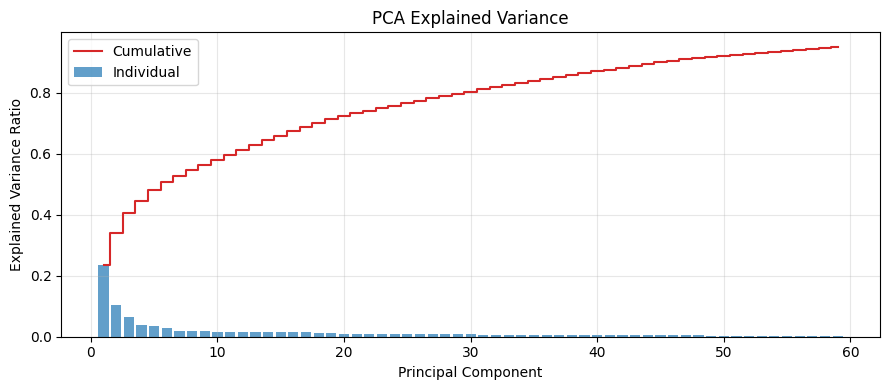


Training Random Forest from scratch (100 trees) ...
  Tree 1/100 — train loss: 2.6388, train acc: 0.6491
  Tree 25/100 — train loss: 0.4983, train acc: 0.9233
  Tree 50/100 — train loss: 0.4981, train acc: 0.9348
  Tree 75/100 — train loss: 0.4991, train acc: 0.9370
  Tree 100/100 — train loss: 0.4963, train acc: 0.9432

=== Loss ===
Scratch log loss: 1.026392
Library log loss: 1.031288

=== Confusion Matrix (rows=true, cols=pred) ===
Class order: ['Downtrend', 'Sideway', 'Uptrend']
Scratch:
 [[  0 150   9]
 [  0 377  18]
 [  0 235  13]]
Library:
 [[  1 153   5]
 [  1 378  16]
 [  1 235  12]]

=== Per-Class Metrics (Scratch) ===
Downtrend  | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | Support: 159
Sideway    | Precision: 0.4948 | Recall: 0.9544 | F1: 0.6517 | Support: 395
Uptrend    | Precision: 0.3250 | Recall: 0.0524 | F1: 0.0903 | Support: 248

=== Per-Class Metrics (Library) ===
Downtrend  | Precision: 0.3333 | Recall: 0.0063 | F1: 0.0123 | Support: 159
Sideway    | Precisio

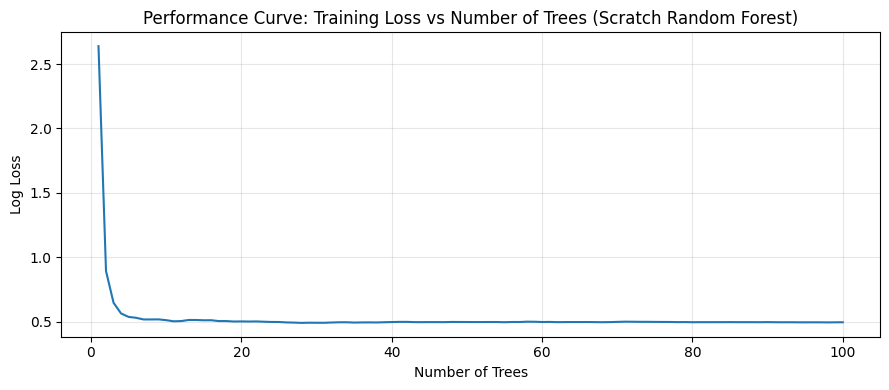

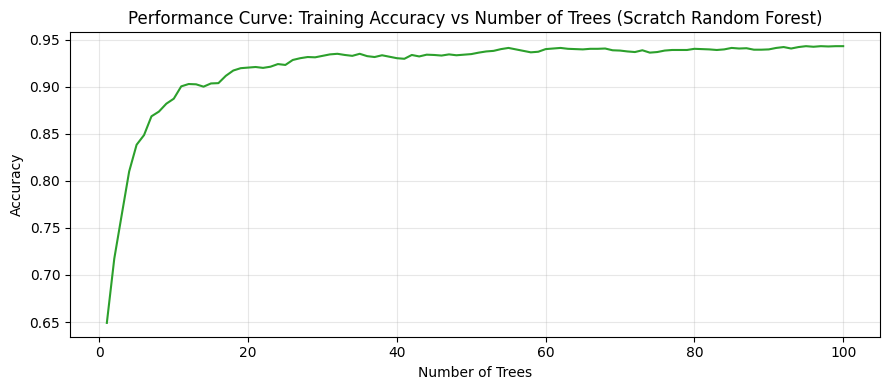

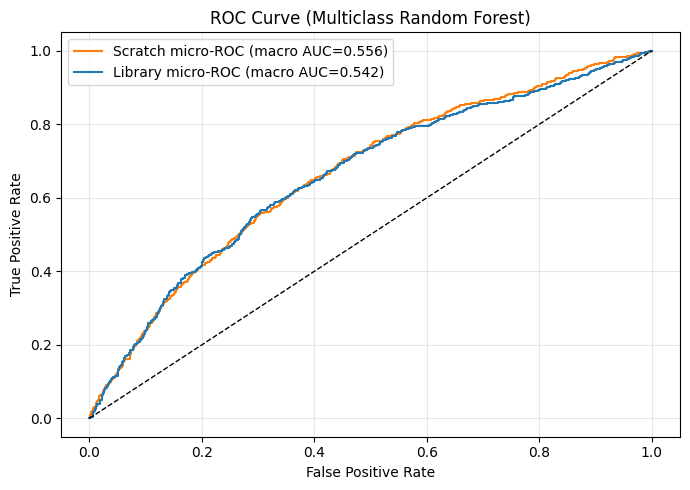

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
from collections import Counter

WINDOW_SIZE = 14
DATA_PATH = '../CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = '../CLASSIFY-AMZN_methods_all_in_one.csv'
TARGET_COL = 'Target_Return_7d'

# Thresholds for 3-class target mapping
UP_THRESHOLD = 0.03
DOWN_THRESHOLD = -0.03

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

requested_features = [
    'ma_gap_20', 'vol_10', 'vol_20',
    'lower_wick', 'upper_wick',
    'ret_1',
    'range_pct',
    'co_ret',
    'ret_5'
]
allowed_features = feature_df['feature'].tolist() if 'feature' in feature_df.columns else []
feature_cols = [c for c in requested_features if c in allowed_features and c in df.columns and c != TARGET_COL]
missing = [c for c in requested_features if c not in feature_cols]
if missing:
    print('Missing features:', missing)

# Basic cleaning and sorting (time series)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features used: {len(feature_cols)}')
print('Features used:', feature_cols)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.int64)

def map_target_3class(y_values, up_thr=0.03, down_thr=-0.03):
    y_cls = np.full_like(y_values, 1, dtype=np.int64)  # 1 = Sideway
    y_cls[y_values > up_thr] = 2                        # 2 = Up
    y_cls[y_values < down_thr] = 0                      # 0 = Down
    return y_cls

CLASS_LABELS = {0: 'Downtrend', 1: 'Sideway', 2: 'Uptrend'}

X_raw = model_df[feature_cols].values.astype(np.float64)
y_raw_cont = model_df[TARGET_COL].values.astype(np.float64)
y_raw = map_target_3class(y_raw_cont, up_thr=UP_THRESHOLD, down_thr=DOWN_THRESHOLD)

print('\nTarget mapping:')
print(f'  > {UP_THRESHOLD:.2f} -> Uptrend (2)')
print(f'  < {DOWN_THRESHOLD:.2f} -> Downtrend (0)')
print('  otherwise -> Sideway (1)')
print('Class distribution:', {CLASS_LABELS[k]: int((y_raw == k).sum()) for k in sorted(CLASS_LABELS)})

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

# Chronological split (80/20)
split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize by train statistics
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train_scaled = (X_train_raw - x_mean) / x_std
X_test_scaled = (X_test_raw - x_mean) / x_std

# -------------------------------------------------
# 3) Dimensionality Reduction with PCA
# -------------------------------------------------
# Keep 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

n_components = pca.n_components_
explained_var = pca.explained_variance_ratio_.sum()
print(f'\n=== PCA Dimensionality Reduction ===')
print(f'Original features (after windowing): {X_train_scaled.shape[1]}')
print(f'Reduced components (95% variance): {n_components}')
print(f'Total explained variance: {explained_var:.4f}')

# Plot explained variance
plt.figure(figsize=(9, 4))
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.7, label='Individual')
plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative', color='tab:red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 4) Random Forest from Scratch (Decision Trees + Bagging)
# ----------------------------------------------------------
class DecisionTreeScratch:
    """Simple CART decision tree for classification (Gini impurity)."""
    def __init__(self, max_depth=10, min_samples_split=5, max_features=None, rng=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.rng = rng if rng is not None else np.random.RandomState(0)
        self.tree = None

    def _gini(self, y):
        if len(y) == 0:
            return 0.0
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1.0 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples < self.min_samples_split:
            return None, None, None

        best_gini = float('inf')
        best_feat = None
        best_thr = None

        # Random feature subset (for random forest)
        if self.max_features is not None and self.max_features < n_features:
            feature_indices = self.rng.choice(n_features, self.max_features, replace=False)
        else:
            feature_indices = np.arange(n_features)

        for feat in feature_indices:
            thresholds = np.unique(X[:, feat])
            if len(thresholds) > 20:
                percentiles = np.linspace(5, 95, 20)
                thresholds = np.percentile(X[:, feat], percentiles)

            for thr in thresholds:
                left_mask = X[:, feat] <= thr
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gini = (left_mask.sum() * self._gini(y[left_mask]) +
                        right_mask.sum() * self._gini(y[right_mask])) / n_samples
                if gini < best_gini:
                    best_gini = gini
                    best_feat = feat
                    best_thr = thr

        return best_feat, best_thr, best_gini

    def _build(self, X, y, depth):
        # Leaf node: majority class
        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) < self.min_samples_split:
            counts = np.bincount(y, minlength=3)
            return {'leaf': True, 'class': np.argmax(counts), 'counts': counts}

        feat, thr, _ = self._best_split(X, y)
        if feat is None:
            counts = np.bincount(y, minlength=3)
            return {'leaf': True, 'class': np.argmax(counts), 'counts': counts}

        left_mask = X[:, feat] <= thr
        right_mask = ~left_mask

        return {
            'leaf': False,
            'feature': feat,
            'threshold': thr,
            'left': self._build(X[left_mask], y[left_mask], depth + 1),
            'right': self._build(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        self.tree = self._build(X, y.astype(np.int64), depth=0)

    def _predict_one(self, x, node):
        if node['leaf']:
            return node['class'], node['counts']
        if x[node['feature']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree)[0] for x in X], dtype=np.int64)

    def predict_leaf_counts(self, X):
        """Return leaf node class counts for each sample (used for probability estimation)."""
        results = []
        for x in X:
            _, counts = self._predict_one(x, self.tree)
            results.append(counts)
        return np.array(results, dtype=np.float64)


class RandomForestScratch:
    """Random Forest classifier from scratch using bootstrap aggregation."""
    def __init__(self, n_estimators=100, max_depth=10, min_samples_split=5,
                 max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.classes_ = None
        self.loss_history = []   # log loss after adding each tree
        self.acc_history = []    # accuracy after adding each tree

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # Determine max_features
        if self.max_features == 'sqrt':
            mf = max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            mf = max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            mf = self.max_features
        else:
            mf = n_features

        self.trees = []
        self.loss_history = []
        self.acc_history = []
        eps = 1e-9

        for t in range(self.n_estimators):
            # Bootstrap sample
            indices = rng.choice(n_samples, n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]

            tree = DecisionTreeScratch(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=mf,
                rng=np.random.RandomState(rng.randint(0, 2**31))
            )
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)

            # Compute cumulative metrics on training data after adding this tree
            proba = self._predict_proba_with_n_trees(X, len(self.trees))
            preds = self.classes_[np.argmax(proba, axis=1)]

            y_onehot = np.zeros((len(y), len(self.classes_)))
            y_onehot[np.arange(len(y)), y] = 1.0
            loss = -np.mean(np.sum(y_onehot * np.log(proba + eps), axis=1))
            acc = np.mean(preds == y)

            self.loss_history.append(loss)
            self.acc_history.append(acc)

            if (t + 1) % 25 == 0 or t == 0:
                print(f'  Tree {t+1}/{self.n_estimators} — train loss: {loss:.4f}, train acc: {acc:.4f}')

    def _predict_proba_with_n_trees(self, X, n_trees):
        """Predict probabilities using the first n_trees."""
        all_counts = np.zeros((len(X), len(self.classes_)), dtype=np.float64)
        for tree in self.trees[:n_trees]:
            leaf_counts = tree.predict_leaf_counts(X)
            # Normalize each tree's counts to probabilities
            row_sums = leaf_counts.sum(axis=1, keepdims=True)
            row_sums = np.where(row_sums == 0, 1.0, row_sums)
            all_counts += leaf_counts / row_sums
        proba = all_counts / n_trees
        # Ensure valid probabilities
        row_sums = proba.sum(axis=1, keepdims=True)
        row_sums = np.where(row_sums == 0, 1.0, row_sums)
        return proba / row_sums

    def predict_proba(self, X):
        return self._predict_proba_with_n_trees(X, len(self.trees))

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]


N_ESTIMATORS = 100
print(f'\nTraining Random Forest from scratch ({N_ESTIMATORS} trees) ...')
scratch_model = RandomForestScratch(
    n_estimators=N_ESTIMATORS, max_depth=12, min_samples_split=5,
    max_features='sqrt', random_state=42
)
scratch_model.fit(X_train, y_train)
y_prob_scratch = scratch_model.predict_proba(X_test)
y_pred_scratch = scratch_model.predict(X_test)

# ------------------------------------------------
# 5) Random Forest Library (scikit-learn)
# ------------------------------------------------
lib_model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS, max_depth=12, min_samples_split=5,
    max_features='sqrt', random_state=42
)
lib_model.fit(X_train, y_train)
y_prob_lib = lib_model.predict_proba(X_test)
y_pred_lib = lib_model.predict(X_test)

# ------------------------
# 6) Metrics and outputs
# ------------------------
classes = np.array([0, 1, 2])

loss_scratch = log_loss(y_test, y_prob_scratch, labels=classes)
loss_lib = log_loss(y_test, y_prob_lib, labels=classes)

cm_scratch = confusion_matrix(y_test, y_pred_scratch, labels=classes)
cm_lib = confusion_matrix(y_test, y_pred_lib, labels=classes)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
acc_lib = accuracy_score(y_test, y_pred_lib)

precision_scratch = precision_score(y_test, y_pred_scratch, average='macro', zero_division=0)
precision_lib = precision_score(y_test, y_pred_lib, average='macro', zero_division=0)

recall_scratch = recall_score(y_test, y_pred_scratch, average='macro', zero_division=0)
recall_lib = recall_score(y_test, y_pred_lib, average='macro', zero_division=0)

f1_scratch = f1_score(y_test, y_pred_scratch, average='macro', zero_division=0)
f1_lib = f1_score(y_test, y_pred_lib, average='macro', zero_division=0)

mse_scratch = mean_squared_error(y_test, y_pred_scratch)
mse_lib = mean_squared_error(y_test, y_pred_lib)
rmse_scratch = np.sqrt(mse_scratch)
rmse_lib = np.sqrt(mse_lib)
r2_scratch = r2_score(y_test, y_pred_scratch)
r2_lib = r2_score(y_test, y_pred_lib)

def multiclass_macro_specificity(cm):
    total = np.sum(cm)
    specs = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = total - (tp + fp + fn)
        specs.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
    return float(np.mean(specs))

specificity_scratch = multiclass_macro_specificity(cm_scratch)
specificity_lib = multiclass_macro_specificity(cm_lib)

print('\n=== Loss ===')
print(f'Scratch log loss: {loss_scratch:.6f}')
print(f'Library log loss: {loss_lib:.6f}')

print('\n=== Confusion Matrix (rows=true, cols=pred) ===')
print('Class order:', [CLASS_LABELS[c] for c in classes])
print('Scratch:\n', cm_scratch)
print('Library:\n', cm_lib)

p_s, r_s, f_s, sup_s = precision_recall_fscore_support(y_test, y_pred_scratch, labels=classes, zero_division=0)
p_l, r_l, f_l, sup_l = precision_recall_fscore_support(y_test, y_pred_lib, labels=classes, zero_division=0)

print('\n=== Per-Class Metrics (Scratch) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_s[i]:.4f} | Recall: {r_s[i]:.4f} | F1: {f_s[i]:.4f} | Support: {sup_s[i]}")

print('\n=== Per-Class Metrics (Library) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_l[i]:.4f} | Recall: {r_l[i]:.4f} | F1: {f_l[i]:.4f} | Support: {sup_l[i]}")

print('\n=== Metrics Summary (Macro) ===')
print(f'Accuracy - Scratch: {acc_scratch:.4f} | Library: {acc_lib:.4f}')
print(f'Precision - Scratch: {precision_scratch:.4f} | Library: {precision_lib:.4f}')
print(f'Recall - Scratch: {recall_scratch:.4f} | Library: {recall_lib:.4f}')
print(f'Specificity - Scratch: {specificity_scratch:.4f} | Library: {specificity_lib:.4f}')
print(f'F1-score - Scratch: {f1_scratch:.4f} | Library: {f1_lib:.4f}')

print('\n=== Additional Numeric Metrics (Label-Encoded) ===')
print(f'MSE - Scratch: {mse_scratch:.4f} | Library: {mse_lib:.4f}')
print(f'RMSE - Scratch: {rmse_scratch:.4f} | Library: {rmse_lib:.4f}')
print(f'R² - Scratch: {r2_scratch:.4f} | Library: {r2_lib:.4f}')

# ROC & AUC (multiclass OvR + micro-curve for plotting)
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc_s = roc_auc_score(y_test_bin, y_prob_scratch, average='macro', multi_class='ovr')
roc_auc_l = roc_auc_score(y_test_bin, y_prob_lib, average='macro', multi_class='ovr')

fpr_s, tpr_s, _ = roc_curve(y_test_bin.ravel(), y_prob_scratch.ravel())
fpr_l, tpr_l, _ = roc_curve(y_test_bin.ravel(), y_prob_lib.ravel())

print('\n=== ROC & AUC (Multiclass OvR Macro AUC) ===')
print(f'Scratch AUC: {roc_auc_s:.4f}')
print(f'Library AUC: {roc_auc_l:.4f}')

# ---------------------------------------------------------
# 7) Performance curves (loss + accuracy) and ROC
# ---------------------------------------------------------
# Performance curve: Loss vs Number of Trees (scratch)
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(scratch_model.loss_history) + 1), scratch_model.loss_history, color='tab:blue')
plt.title('Performance Curve: Training Loss vs Number of Trees (Scratch Random Forest)')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Performance curve: Accuracy vs Number of Trees (scratch)
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(scratch_model.acc_history) + 1), scratch_model.acc_history, color='tab:green')
plt.title('Performance Curve: Training Accuracy vs Number of Trees (Scratch Random Forest)')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ROC Curve (micro-averaged one-vs-rest)
plt.figure(figsize=(7, 5))
plt.plot(fpr_s, tpr_s, label=f'Scratch micro-ROC (macro AUC={roc_auc_s:.3f})', color='tab:orange')
plt.plot(fpr_l, tpr_l, label=f'Library micro-ROC (macro AUC={roc_auc_l:.3f})', color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curve (Multiclass Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()